In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

data_dir = "./data"

device = torch.device("cpu")

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")

if torch.cuda.is_available():
    device = torch.device("cuda")

print(f"Data resides in        : {data_dir}")
print(f"Training model on      : {str(device)}")

Data resides in        : ./data
Training model on      : mps


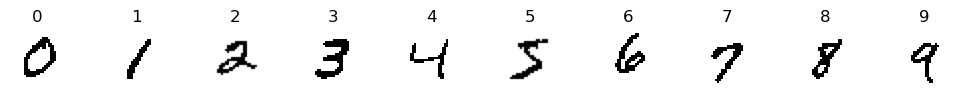

In [2]:
def print_samples(samples, elements_per_row=10, fig_width=10, cmap="binary"):
    num_digits = len(samples)
    num_rows = (num_digits + elements_per_row - 1) // elements_per_row

    plt.figure(figsize=(fig_width, fig_width / elements_per_row * num_rows))
    for idx, (label, image) in enumerate(samples):
        plt.subplot(num_rows, elements_per_row, idx + 1)
        plt.imshow(image.squeeze(), cmap=cmap)
        plt.title(label, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# load MNIST and convert it to binary directly in transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),               # normalize to [0, 1]
    transforms.Lambda(lambda x: (x > 0.5).float())  # binarize
])

train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

sample_list = [(label, next(image for image, lbl in train_dataset if lbl == label)) for label in range(10)]
print_samples(sample_list)

In [38]:
class RBM(nn.Module):
    def __init__(self, visible_dim, hidden_dim=128, W_var=0.01, a_val=0.0, b_val=0.0):
        super().__init__()
        self.W = nn.Parameter(torch.randn(visible_dim, hidden_dim) * W_var)
        self.a = nn.Parameter(torch.full((visible_dim,), a_val))
        self.b = nn.Parameter(torch.full((hidden_dim,), b_val))
        self.register_buffer('persistent_chain', None) # Persistent chain buffer

    def sample_hidden(self, v):
        h_probs = torch.sigmoid(v @ self.W + self.b)
        h_sample = torch.bernoulli(h_probs)
        return h_probs, h_sample

    def sample_visible(self, h):
        v_probs = torch.sigmoid(h @ self.W.t() + self.a)
        v_sample = torch.bernoulli(v_probs)
        return v_probs, v_sample

    def sample_gibbs(self, v0_sample, k=1):
        vk_probs, vk_sample = v0_sample.clone(), torch.zeros(v0_sample.size())
        hk_probs, hk_sample = self.sample_hidden(v0_sample)

        for _ in range(k):
            vk_probs, vk_sample = self.sample_visible(hk_sample)
            hk_probs, hk_sample = self.sample_hidden(vk_sample)

        return hk_probs, hk_sample, vk_probs, vk_sample # Returns 4 values

    def contrastive_divergence(self, v0_sample, k=1, lr=0.01):
        h0_probs, h0_sample = self.sample_hidden(v0_sample)
        hk_probs, _, vk_probs, vk_sample = self.sample_gibbs(v0_sample, k)

        batch_size = v0_sample.size(0)
        positive_association = (v0_sample.T @ h0_probs) / batch_size
        negative_association = (vk_sample.T @ hk_probs) / batch_size

        self.W.data += lr * (positive_association - negative_association)
        self.a.data += lr * (v0_sample.mean(dim=0) - vk_sample.mean(dim=0))
        self.b.data += lr * (h0_probs.mean(dim=0) - hk_probs.mean(dim=0))

        return vk_sample

    def generate(self, k=50):
        # Initialize from a completely random visible state for EACH generation
        v_init = torch.bernoulli(torch.rand(1, self.a.numel())).to(self.a.device) # Random initial visible state
        hk_probs, hk_sample, v_probs, v_sample = self.sample_gibbs(v_init, k) # Start Gibbs from random state
        return v_probs # Return visible probabilities

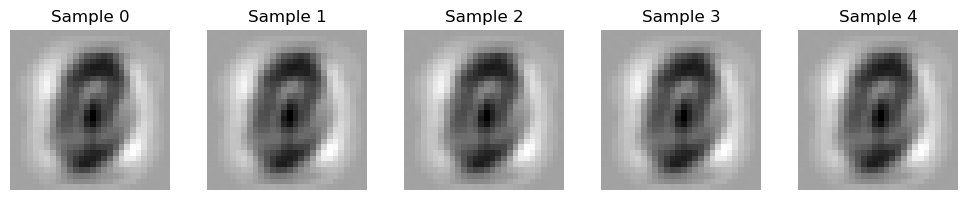

Epoch 220/500 : Loss 49.0670


KeyboardInterrupt: 

In [49]:
from IPython.display import clear_output


# --- Hyperparameter Settings (ADJUST THESE) ---
hidden_dim = 128  # or 256
batch_size = 256
epochs = 500
lr = 0.005
gibbs_steps = 1
generation_steps = 20

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

visible_dim = train_dataset[0][0].numel()
rbm = RBM(visible_dim, hidden_dim).to(device)

metrics = {}
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch, _ in train_loader:
        flat_batch = batch.view(-1, visible_dim).to(device)
        recon_batch = rbm.contrastive_divergence(flat_batch, k=gibbs_steps, lr=lr) # Pass lr here

        loss = torch.mean(torch.sum((flat_batch - recon_batch) ** 2, dim=1))
        epoch_loss += loss.item()

    metrics[epoch] = { "reconstruction_error": epoch_loss / len(train_loader) }

    clear_output(wait=True)

    # --- VISUALIZATION & MONITORING (after each epoch) ---
    with torch.no_grad(): # Important: No gradients during visualization
        # 1. Generate and Display Fantasy Samples
        generated_images = torch.stack([rbm.generate(k=generation_steps) for _ in range(5)])
        generated_images = generated_images.view(-1, 28, 28).cpu()
        print("Generated Samples:")
        print_samples([(f"Sample {idx}", sample) for idx, sample in enumerate(generated_images)], elements_per_row=5, cmap="gray")

    print(f"Epoch {epoch + 1}/{epochs} : Loss {metrics[epoch]['reconstruction_error']:.4f}")


--- Training Complete ---
Generating fantasy images *after* training...
Fantasy Images (Generated *after* training):


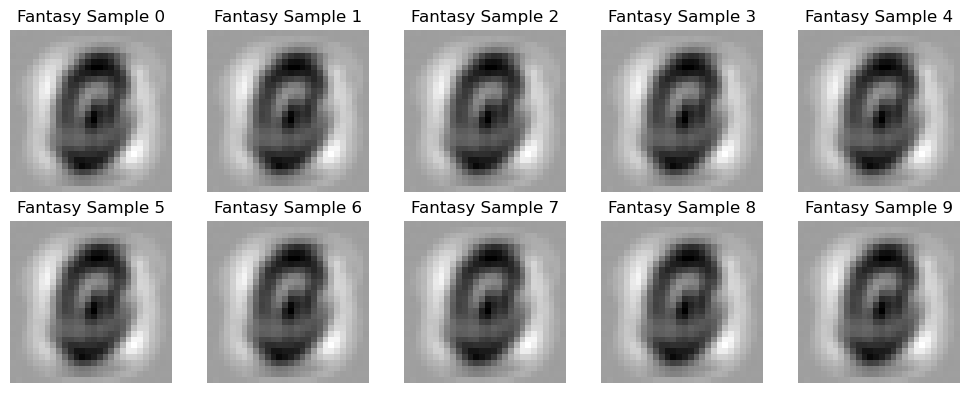

Final Fantasy image generation complete.


In [42]:
# --- After your training loop (for epoch in range(epochs): ...) add this: ---

print("\n--- Training Complete ---") # Indicate training finished

# --- GENERATE FANTASY IMAGES AFTER TRAINING ---
generation_steps_final = 1000  # <--- ADJUST: Gibbs steps for final generation (e.g., 200, 500)
num_fantasy_samples_final = 10 # <--- ADJUST: Number of fantasy images (e.g., 25 for 5x5 grid)

with torch.no_grad(): # No gradients for final generation
    print("Generating fantasy images *after* training...")
    fantasy_images_final = torch.stack([rbm.generate(k=generation_steps_final) for _ in range(num_fantasy_samples_final)])
    fantasy_images_final = fantasy_images_final.view(-1, 28, 28).cpu()

# --- Display Fantasy Images AFTER Training ---
print("Fantasy Images (Generated *after* training):")
print_samples([(f"Fantasy Sample {idx}", img) for idx, img in enumerate(fantasy_images_final)], elements_per_row=5, cmap="gray")

print("Final Fantasy image generation complete.")

In [20]:
hidden_dim = 256  # or 256
batch_size = 256
epochs = 3
lr = 0.01  # Keep original LR for now
gibbs_steps = 1


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


visible_dim = train_dataset[0][0].numel()
rbm = RBM(visible_dim, hidden_dim).to(device)


metrics = {}
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch, _ in train_loader:
        flat_batch = batch.view(-1, visible_dim).to(device)

        recon_batch = rbm.contrastive_divergence(flat_batch, k=gibbs_steps)

        loss = torch.mean(torch.sum((flat_batch - recon_batch) ** 2, dim=1))
        epoch_loss += loss.item()

    metrics[epoch] = { "reconstruction_error": epoch_loss / len(train_loader) }
    print(f"Epoch {epoch + 1}/{epochs} : Loss {metrics[epoch]['reconstruction_error']:.4f}")

Epoch 1/50 : Loss 160.0304
Epoch 2/50 : Loss 124.7320
Epoch 3/50 : Loss 107.4343
Epoch 4/50 : Loss 98.3042
Epoch 5/50 : Loss 92.6027
Epoch 6/50 : Loss 88.2224
Epoch 7/50 : Loss 84.6489
Epoch 8/50 : Loss 81.7268
Epoch 9/50 : Loss 79.1431
Epoch 10/50 : Loss 76.9314
Epoch 11/50 : Loss 74.9240
Epoch 12/50 : Loss 73.1541
Epoch 13/50 : Loss 71.4754
Epoch 14/50 : Loss 69.9827
Epoch 15/50 : Loss 68.6324
Epoch 16/50 : Loss 67.3686
Epoch 17/50 : Loss 66.3129
Epoch 18/50 : Loss 65.2111
Epoch 19/50 : Loss 64.2088
Epoch 20/50 : Loss 63.3156
Epoch 21/50 : Loss 62.4470
Epoch 22/50 : Loss 61.6017
Epoch 23/50 : Loss 60.8455
Epoch 24/50 : Loss 60.1378
Epoch 25/50 : Loss 59.4604
Epoch 26/50 : Loss 58.8189
Epoch 27/50 : Loss 58.1951
Epoch 28/50 : Loss 57.5997
Epoch 29/50 : Loss 57.0190
Epoch 30/50 : Loss 56.5234
Epoch 31/50 : Loss 55.9692
Epoch 32/50 : Loss 55.5211
Epoch 33/50 : Loss 55.0222
Epoch 34/50 : Loss 54.5780
Epoch 35/50 : Loss 54.1505
Epoch 36/50 : Loss 53.7145
Epoch 37/50 : Loss 53.2990
Epoch 3

Text(0, 0.5, 'Reconstruction Error')

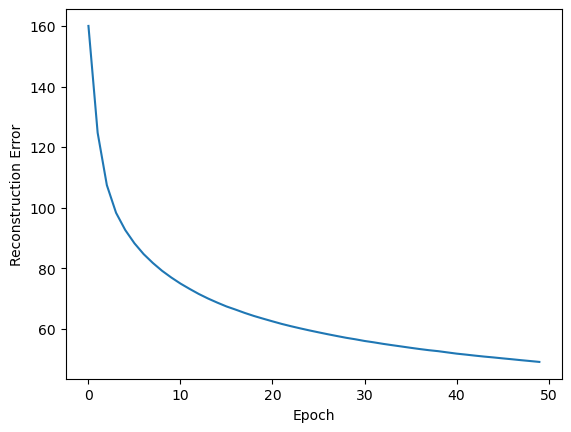

In [21]:
# only plot the reconstruction_error
plt.plot([metrics[epoch]['reconstruction_error'] for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

In [23]:
generation_steps = 10

with torch.no_grad():
    random_samples = torch.bernoulli(torch.rand(10, visible_dim)).to(device)
    generated_images = torch.stack([rbm.generate(k=generation_steps) for _ in range(10)])

    generated_images = generated_images.view(-1, 28, 28).cpu()

# Display generated images
print_samples([(f"Sample {idx}", sample) for idx, sample in enumerate(generated_images)], elements_per_row=5, cmap="gray")

ValueError: too many values to unpack (expected 2)